In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.backend import clear_session
import gc
#from eli5.sklearn import PermutationImportance

In [72]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [73]:
mask = data["support"] == "Fixed_Free"
data = data.drop(data[mask].index)

In [74]:
data["total_length"] = data["length1"] + data["length2"]
data["x_length"] = data["length2"] + data["x_deformation_position"]
data["x_ratio"] = data["x_length"]/data["total_length"]
data["flange_postion_ratio"] = data["length2"]/data["total_length"]

In [75]:
data["x_ratio"].max()

0.9167613636363637

In [76]:
mask2= data["x_ratio"] == 1
print(mask2)
data = data.drop(data[mask2].index)

0        False
1        False
2        False
3        False
4        False
         ...  
12284    False
12285    False
12286    False
12287    False
12288    False
Name: x_ratio, Length: 9352, dtype: bool


In [77]:
to_drop=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "y_deformation_position", "z_deformation_position","x_deformation_position",
        "support_right", "support_left","length1", "length2", "x_length"
        ]
to_keep=["pipe_dn","pipe_schedule","flange_class",
        "total_length", "x_ratio","flange_postion_ratio"
        "lumped_mass", "frequency",
        "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [80]:
numeric_features = ["pipe_dn", 'total_length', 'lumped_mass',
                    "flange_postion_ratio"]
categorical_features = ['support','flange_class','pipe_schedule']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [81]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [82]:
output_columns = ['allowable_deformation', 'frequency', 'x_ratio']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [84]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [85]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()
scaler_y_x_ratio = StandardScaler()


#y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
#y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

#y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
#y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))

y_train_transformed_x_ratio = scaler_y_x_ratio.fit_transform(pd.DataFrame(y_train["x_ratio"]))
y_test_transformed_x_ratio = scaler_y_x_ratio.transform(pd.DataFrame(y_test["x_ratio"]))

#y_train_transformed_x_ratio = np.array(y_train["x_ratio"])
#y_test_transformed_x_ratio = np.array(y_test["x_ratio"])

In [86]:
logdir = "logs/x_ratio_measurements/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [87]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(256, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(64, activation='relu')(dropout1)



# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [88]:
model = Model(inputs=input_layer, outputs=output_layer)

In [89]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,609 (80.50 KB)

 Trainable params: 20,609 (80.50 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='mse',
              metrics=["R2Score"])

In [91]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_x_ratio,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - R2Score: 0.4073 - loss: 0.5534 - val_R2Score: 0.7292 - val_loss: 0.2487
Epoch 2/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.6641 - loss: 0.3426 - val_R2Score: 0.7628 - val_loss: 0.2179
Epoch 3/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.7148 - loss: 0.2766 - val_R2Score: 0.7842 - val_loss: 0.1983
Epoch 4/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.7246 - loss: 0.2804 - val_R2Score: 0.7904 - val_loss: 0.1926
Epoch 5/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.7388 - loss: 0.2635 - val_R2Score: 0.7979 - val_loss: 0.1857
Epoch 6/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.7476 - loss: 0.2621 - val_R2Score: 0.8123 - val_loss: 0.1724
Epoch 7/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.7558 - loss: 0.2497 - val_R2Score: 0.8006 - val_loss: 0.1831
Epoch 8/200
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.7882 - loss: 0.2092 - val_R2Score: 0.8107 - 

In [34]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_x_ratio)
print('Test accuracy:', test_mse)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: 0.5532 - loss: 0.8926
Test accuracy: 0.692797839641571


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,293 (235.52 KB)

 Trainable params: 20,097 (78.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,196 (157.02 KB)

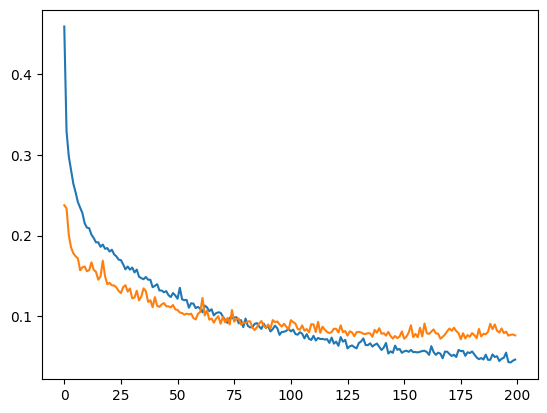

In [22]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [23]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_x_ratio.inverse_transform((predictions_scaled))
#predictions = predictions_scaled

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [24]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df)


Sample Predictions:
             0
0     0.543343
1     0.492323
2     0.581749
3     0.544558
4     0.625085
...        ...
1866  0.568804
1867  0.484705
1868  0.502377
1869  0.481850
1870  0.532203

[1871 rows x 1 columns]


In [25]:
y_test["x_ratio"]

1772     0.546900
9378     0.491722
6933     0.581621
1388     0.536468
7101     0.616474
           ...   
6919     0.565273
2744     0.484376
432      0.493169
10611    0.475054
8969     0.531503
Name: x_ratio, Length: 1871, dtype: float64

In [26]:
true= y_test["x_ratio"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

0.0010740175581047738

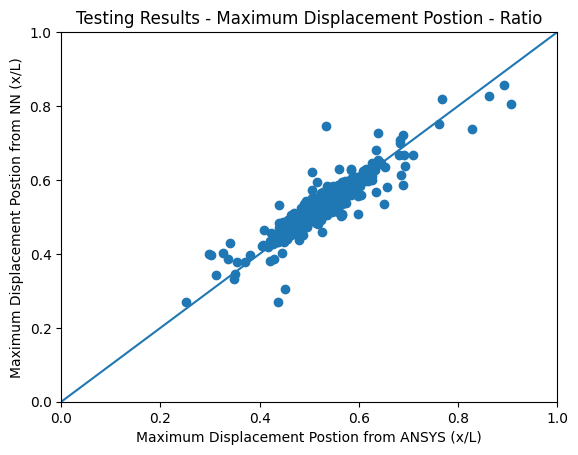

In [27]:
pred=predictions_df
ansys=y_test["x_ratio"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 1],[0, 1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Maximum Displacement Postion from ANSYS (x/L)")
plt.ylabel("Maximum Displacement Postion from NN (x/L)")
plt.title("Testing Results - Maximum Displacement Postion - Ratio")
plt.show()

In [28]:
#clear_session()
#del model
gc.collect()

4253

In [29]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          data:  1.5 MiB
                             x:  1.3 MiB
                       x_train:  1.1 MiB
           x_train_transformed: 759.9 KiB
                         mask2: 340.3 KiB
                             y: 292.3 KiB
                        x_test: 272.3 KiB
                       y_train: 233.8 KiB
            x_test_transformed: 190.1 KiB
   y_train_transformed_x_ratio: 58.6 KiB


In [30]:
model.layers[1].get_weights()[0]

array([[-0.28849706,  0.3445137 , -0.11161852, ..., -0.25883624,
        -0.08406821,  0.16145158],
       [ 0.01968577, -0.00747482, -0.06174312, ..., -0.04428767,
         0.0974533 ,  0.0754815 ],
       [ 0.10767004, -0.29377437, -0.10298949, ..., -0.10653404,
        -0.03565434,  0.02904079],
       ...,
       [-0.090367  ,  0.06302632, -0.18559924, ..., -0.19277558,
         0.11004288,  0.19458523],
       [-0.0822434 ,  0.03871959, -0.14437453, ..., -0.24594814,
        -0.46459922, -0.59530854],
       [-0.49150518,  0.05252726, -0.29201046, ..., -0.17551358,
         0.0555915 ,  0.20481467]], dtype=float32)

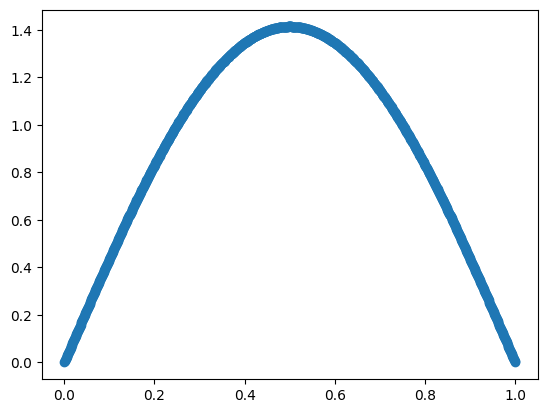

In [31]:
x=np.linspace(0,1,1000)
y = 2**0.5*np.sin(np.pi*x)
plt.scatter(x,y)

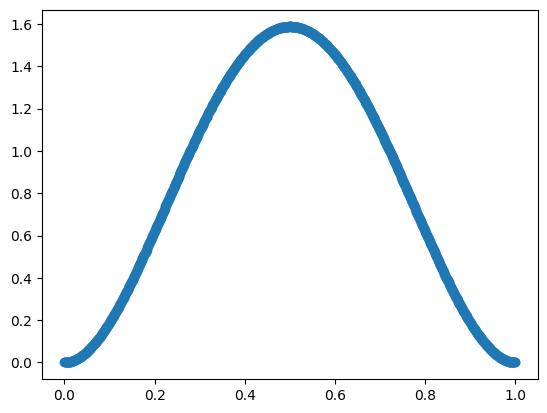

In [32]:
x=np.linspace(0,1,1000)
b=4.73
c=0.9825
y = np.cosh(b*x)-np.cos(b*x)-c*(np.sinh(b*x)-np.sin(b*x))
plt.scatter(x,y)

0.5805805805805806


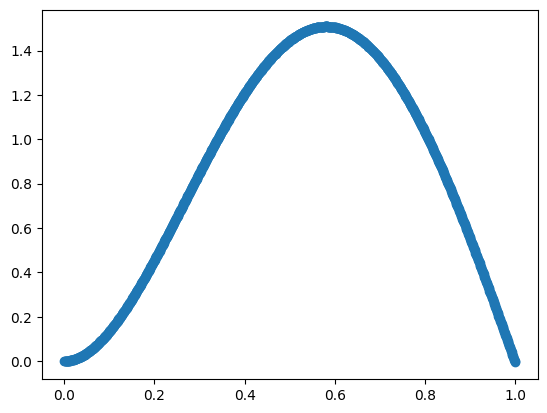

In [33]:
x=np.linspace(0,1,1000)
b=3.927
c=1.001
y = np.cosh(b*x)-np.cos(b*x)-c*(np.sinh(b*x)-np.sin(b*x))
plt.scatter(x,y)

m=y.max()
for i in x:
    a = np.cosh(b*i)-np.cos(b*i)-c*(np.sinh(b*i)-np.sin(b*i))
    if m==a:
        print(i)